In [2]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from typing import List, Tuple

In [3]:
IMG_DIR = "../images/train/img"
MASK_DIR = "../images/train/mask"
CROPPED_DIR = "../cropped_images"
RESULT_DIR = "../filtering_results/"

In [4]:
def crop_images(source_dir: str, destination_dir: str):
    image_names = os.listdir(source_dir)

    for img_name in image_names:
        img = cv2.imread(f"{source_dir}/{img_name}")
        cropped = img[:, 20:-19]
        cv2.imwrite(f"{destination_dir}/{img_name}", cropped)

        print(f"Image {img_name} successfully cropped.")

crop_images(IMG_DIR, "../cropped_images/img")
crop_images(MASK_DIR, "../cropped_images/mask")

Image Image_10L.jpg successfully cropped.
Image Image_09L.jpg successfully cropped.
Image Image_01R.jpg successfully cropped.
Image Image_07R.jpg successfully cropped.
Image Image_09R.jpg successfully cropped.
Image Image_02R.jpg successfully cropped.
Image Image_03R.jpg successfully cropped.
Image Image_04L.jpg successfully cropped.
Image Image_05R.jpg successfully cropped.
Image Image_04R.jpg successfully cropped.
Image Image_02L.jpg successfully cropped.
Image Image_03L.jpg successfully cropped.
Image Image_08R.jpg successfully cropped.
Image Image_11L.jpg successfully cropped.
Image Image_05L.jpg successfully cropped.
Image Image_06L.jpg successfully cropped.
Image Image_07L.jpg successfully cropped.
Image Image_08L.jpg successfully cropped.
Image Image_10R.jpg successfully cropped.
Image Image_06R.jpg successfully cropped.
Image Image_01L.jpg successfully cropped.
Image Image_08R_1stHO.png successfully cropped.
Image Image_04L_1stHO.png successfully cropped.
Image Image_11L_1stHO.

In [5]:
def process_image(image_path: str):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    green = image[:, :, 1] # use green channel
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(7,7)) 
    img_clahe = clahe.apply(green) # make clahe form green channel

    kernel_sizes = [5,7,15,23]
    kernels = [cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(size, size)) for size in kernel_sizes]

    morphology_steps = [img_clahe.copy()]
    for kernel in kernels:
        image_opened = cv2.morphologyEx(morphology_steps[-1], cv2.MORPH_OPEN, kernel, iterations = 1)
        image_closed = cv2.morphologyEx(image_opened, cv2.MORPH_CLOSE, kernel, iterations = 1)
        morphology_steps.extend([image_opened, image_closed])

    extracted_vessels = cv2.subtract(morphology_steps[-1], img_clahe) # extract vessels

    extracted_clahe = clahe.apply(extracted_vessels) # make clahe from extracted vessels

    ret, extracted_clahe_thresh = cv2.threshold(extracted_clahe, 20, 255, cv2.THRESH_BINARY) # threshold

    noise = np.ones(extracted_clahe_thresh.shape[:2], dtype='uint8') * 255  # create noise mask

    contours, hierarchy = cv2.findContours(extracted_clahe_thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE) # find contours

    for contour in contours:
        if cv2.contourArea(contour) <= 200:
            cv2.drawContours(noise, [contour], -1, 0, -1)

    extracted_vessels_without_noise = cv2.bitwise_and(extracted_clahe, extracted_clahe, mask=noise) # remove noise

    ret, extracted_vessels_without_noise_thresh = cv2.threshold(extracted_vessels_without_noise, 20, 255, cv2.THRESH_BINARY) #threshold

    result_img = extracted_vessels_without_noise_thresh

    return result_img

img = process_image(f"{CROPPED_DIR}/img/Image_01L.jpg")

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


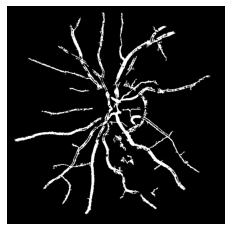

In [14]:
fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [18]:
def process_all(source_dir: str, result_dir: str):
    img_names = os.listdir(f"{source_dir}")

    for img_name in img_names:
        processed = process_image(f"{source_dir}/{img_name}")
        cv2.imwrite(f"{result_dir}/{img_name}", processed)

        print(f"Image {img_name} successfully processed.")
process_all(f"{CROPPED_DIR}/img", RESULT_DIR)

Image Image_10L.jpg successfully cropped.
Image Image_09L.jpg successfully cropped.
Image Image_01R.jpg successfully cropped.
Image Image_07R.jpg successfully cropped.
Image Image_09R.jpg successfully cropped.
Image Image_02R.jpg successfully cropped.
Image Image_03R.jpg successfully cropped.
Image Image_04L.jpg successfully cropped.
Image Image_05R.jpg successfully cropped.
Image Image_04R.jpg successfully cropped.
Image Image_02L.jpg successfully cropped.
Image Image_03L.jpg successfully cropped.
Image Image_08R.jpg successfully cropped.
Image Image_11L.jpg successfully cropped.
Image Image_05L.jpg successfully cropped.
Image Image_06L.jpg successfully cropped.
Image Image_07L.jpg successfully cropped.
Image Image_08L.jpg successfully cropped.
Image Image_10R.jpg successfully cropped.
Image Image_06R.jpg successfully cropped.
Image Image_01L.jpg successfully cropped.


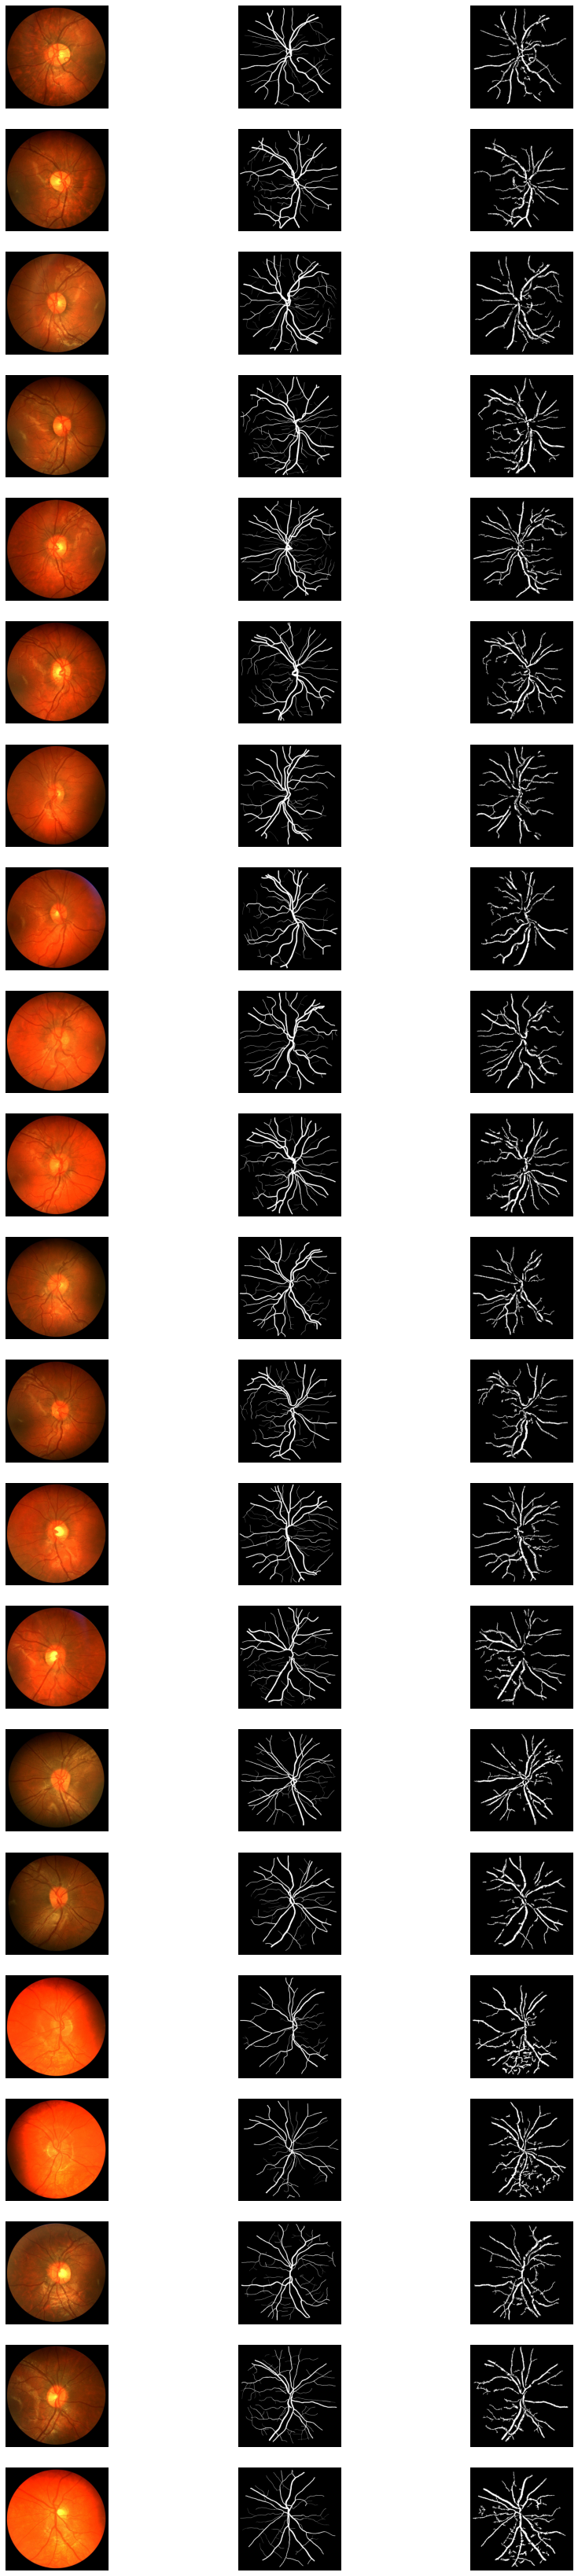

In [28]:
image_names = sorted(os.listdir(f"{CROPPED_DIR}/img"))
image_names = [f"{CROPPED_DIR}/img/{img_name}" for img_name in image_names]
mask_names = sorted(os.listdir(f"{CROPPED_DIR}/mask"))
mask_names = [f"{CROPPED_DIR}/mask/{mask_name}" for mask_name in mask_names]
result_names = sorted(os.listdir(f"{RESULT_DIR}"))
result_names = [f"{RESULT_DIR}/{result_name}" for result_name in result_names]
results = list(zip(image_names, mask_names, result_names))

fig, axs = plt.subplots(len(results), 3)
fig.set_figwidth(15)
fig.set_figheight(60)

for idy, result in enumerate(results):
    for idx, img_path in enumerate(result):
        img = cv2.imread(img_path)
        if idx % 3 == 0:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axs[idy, idx].imshow(img)
        else:
            axs[idy, idx].imshow(img, cmap='gray')
        axs[idy, idx].spines['top'].set_visible(False)
        axs[idy, idx].spines['left'].set_visible(False)
        axs[idy, idx].spines['bottom'].set_visible(False)
        axs[idy, idx].spines['right'].set_visible(False)
        axs[idy, idx].set_xticks([])
        axs[idy, idx].set_yticks([])
plt.show()
